In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
import pandas as pd
from utils.evaluation import MetaQA_Dataset
from utils.graph import KGraphPreproc
import matplotlib.pyplot as plt
from utils.preprocessing import preprocess_text
from utils.scores import calculate_em_accuracy, calculate_f1_accuracy, get_rouge_score_for_answers
import networkx as nx
from utils.plot import get_broken_figure
import os
import ast
import re

In [369]:
metaqa_eval = MetaQA_Dataset()

In [411]:
metaqa_eval.tabulate_performance()

MetaQA
+-----------+--------+--------+--------+--------+--------+--------+
| Method    |   1hop |   1hop |   2hop |   2hop |   3hop |   3hop |
|           |     EM |     F1 |     EM |     F1 |     EM |     F1 |
+===========+========+========+========+========+========+========+
| bline     |  0.327 |  0.295 |  0.228 |  0.114 |  0.32  |  0.204 |
+-----------+--------+--------+--------+--------+--------+--------+
| bline2    |  0.319 |  0.294 |  0.231 |  0.115 |  0.32  |  0.198 |
+-----------+--------+--------+--------+--------+--------+--------+
| kb-path   |  0.951 |  0.956 |  0.943 |  0.93  |  0.95  |  0.948 |
+-----------+--------+--------+--------+--------+--------+--------+
| kb1       |  0.858 |  0.811 |  0.164 |  0.127 |  0.36  |  0.286 |
+-----------+--------+--------+--------+--------+--------+--------+
| kb2       |  0.836 |  0.763 |  0.694 |  0.642 |  0.439 |  0.303 |
+-----------+--------+--------+--------+--------+--------+--------+
| kb3       |  0.865 |  0.72  |  0.26  | 

In [6]:
mqa_graph = KGraphPreproc.get_metaqa_graph()

In [7]:
import re
regex_mqa_topic_entity = re.compile("\[(.*?)\]")
def extract_mqa_topic_entity(question):
    return regex_mqa_topic_entity.findall(question)[0]

In [412]:
mqa = pd.DataFrame(columns=["id", "hop", "Question", "topic_entity", "Answers"])
mqa

,id,hop,Question,topic_entity,Answers


In [413]:
hops = [1,2,3]
for hop in hops:
    test_set_path = f"/datasets/MetaQA/{hop}hop/test_1000.txt"
    tset = pd.read_csv(test_set_path, header=None, index_col="qid", names=["qid", "Question", "Answers"])
    tset.rename(columns={0: "Question", 1: "Answers"}, inplace=True)
    tset["topic_entity"] = tset.Question.apply(extract_mqa_topic_entity)
    tset.Answers = tset.apply(lambda t: set(t.Answers.lower().split("|")), axis=1)
    # tset = tset.explode("Answer")
    # tset["Answer"] = tset.Answer.apply(preprocess_text)
    tset["id"] = tset.apply(lambda r: f"{hop}-{r.name}", axis=1)
    tset.set_index("id", inplace=True)
    tset["hop"] = hop
    print(tset.columns)
    mqa = pd.concat([mqa, tset])
mqa.dropna(inplace=True, how="all")
print("Total unique question-answer pairs:", len(mqa))

Index(['Question', 'Answers', 'topic_entity', 'hop'], dtype='object')
Index(['Question', 'Answers', 'topic_entity', 'hop'], dtype='object')
Index(['Question', 'Answers', 'topic_entity', 'hop'], dtype='object')
Total unique question-answer pairs: 3000


In [11]:
"""get path lengths"""
# mqa["path"] = mqa.apply(
#     lambda r: [nx.shortest_path(
#         mqa_graph._graph,
#         mqa_graph.name2mid[r["topic_entity"]],
#         mqa_graph.preprocessed_nodes.get(answer, None)
#     ) for answer in r["Answers"]],
#     axis=1
# )

'get path lengths'

In [260]:
mqa.drop_duplicates(["Question", "topic_entity"], inplace=True)
mqa.head(2)

,id,hop,Question,topic_entity,Answers
1-3710,NaN,1,who is the director that directed [Big Jake],Big Jake,"{george sherman, john wayne}"
1-5313,NaN,1,what words describe [The Front Page],The Front Page,"{jack lemmon, billy wilder, walter matthau}"


In [334]:
p = re.compile(r",|\|")

In [414]:
for r_set in metaqa_eval.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    print(set_name, end=" ")
    for hop in [1,2,3]:
        print(hop, end=" ")
        if not os.path.exists(r_set.format(hop=f"{hop}hop")):
            continue
        results_df = pd.read_csv(r_set.format(hop=f"{hop}hop"), index_col=0)
        if set_name == "tog-lp-4":
            results_df = pd.read_csv(r_set.format(hop=f"{hop}hop"), index_col=0)
            results_df.Model = results_df.Model.apply(lambda t: ast.literal_eval(t)[0])
        results_df["Model"] = results_df.apply(lambda t: p.split(str(t.Model)), axis=1)
        results_df.rename(columns={"Model": set_name}, inplace=True)
        results_df.index = results_df.index.map(lambda x: f"{hop}-{x}")
        mqa = mqa.merge(results_df, how="left", left_index=True, right_index=True)
        if (set_name+"_x" in mqa) and (set_name+"_y" in mqa):
            mqa[set_name] = mqa[set_name+"_x"].combine_first(mqa[set_name+"_y"])
            mqa.drop(columns=[set_name+"_x", set_name+"_y"], inplace=True)
    print()
    mqa.fillna("", inplace=True)
    mqa[set_name+"_EM"] = mqa.apply(lambda t: calculate_em_accuracy(t.Answers, t[set_name]), axis=1)
    mqa[set_name+"_F1"] = mqa.apply(lambda t: calculate_f1_accuracy(t.Answers, t[set_name]), axis=1)
    
    

bline 1 2 3 


/tmp/ipykernel_2800/2870359785.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mqa.fillna("", inplace=True)


bline2 1 2 3 
kb-path 1 2 3 
kb1 1 2 3 
kb2 1 2 3 
kb3 1 2 3 


/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


kb4 1 2 3 


/tmp/ipykernel_2800/2870359785.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mqa.fillna("", inplace=True)


sbert-kb1 1 2 3 
sbert-kb2 1 2 3 
sbert-kb3 1 2 3 
sbert-kb4 1 2 3 
tog-lp-4 1 2 3 


In [394]:
set_names = [r.split("/")[-1].split(".")[0] for r in metaqa_eval.result_set_paths]
set_names

['bline',
 'bline2',
 'kb-path',
 'kb1',
 'kb2',
 'kb3',
 'kb4',
 'sbert-kb1',
 'sbert-kb2',
 'sbert-kb3',
 'sbert-kb4',
 'tog-lp-4']

In [393]:
mqa.columns

Index(['id', 'hop', 'Question', 'topic_entity', 'Answers', 'bline', 'bline_EM',
       'bline_F1', 'bline2', 'bline2_EM', 'bline2_F1', 'kb-path', 'kb-path_EM',
       'kb-path_F1', 'kb1', 'kb1_EM', 'kb1_F1', 'kb2', 'kb2_EM', 'kb2_F1',
       'kb3', 'kb3_EM', 'kb3_F1', 'kb4', 'kb4_EM', 'kb4_F1', 'sbert-kb1',
       'sbert-kb1_EM', 'sbert-kb1_F1', 'sbert-kb2', 'sbert-kb2_EM',
       'sbert-kb2_F1', 'sbert-kb3', 'sbert-kb3_EM', 'sbert-kb3_F1',
       'sbert-kb4', 'sbert-kb4_EM', 'sbert-kb4_F1', 'tog-lp-4', 'tog-lp-4_EM',
       'tog-lp-4_F1'],
      dtype='object')

In [339]:
mqa[mqa.hop == 3][["bline"]].loc["3-2807"].values

array([list(['Alexander Aja (High Tension', ' Crawl) ', ' Joe Dante (Gremlins', ' Small Soldiers)'])],
      dtype=object)

In [415]:
mqa_res = mqa[["hop", 
               *[s+"_EM" for s in set_names],
                *[s+"_F1" for s in set_names],
                # *[s+"_rouge" for s in set_names],
                # *[s+"_correct" for s in set_names]
               ]]
mqa_res.head()

,hop,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,sbert-kb1_EM,sbert-kb2_EM,...,kb-path_F1,kb1_F1,kb2_F1,kb3_F1,kb4_F1,sbert-kb1_F1,sbert-kb2_F1,sbert-kb3_F1,sbert-kb4_F1,tog-lp-4_F1
1-3710,1,0,0,1,1,1,0,0,1,1,...,1.0,1.000000,1.0,0.0,0.0,1.00,1.00,0.444444,1.000000,1.000000
1-5313,1,0,0,1,1,0,0,0,1,0,...,1.0,0.400000,0.0,0.0,0.0,0.25,0.00,0.000000,0.000000,0.041667
1-5479,1,0,0,0,0,0,0,0,0,1,...,0.0,0.142857,0.0,0.133333,0.0,0.16,0.25,0.200000,0.333333,0.000000
1-1253,1,0,0,1,1,1,1,0,1,1,...,1.0,1.000000,1.0,0.5,0.0,1.00,1.00,0.500000,1.000000,0.040850
1-9668,1,0,0,1,1,1,1,0,1,1,...,1.0,1.000000,1.0,1.0,0.0,1.00,1.00,1.000000,1.000000,0.005333


In [263]:
def cast_to_float(x):
    try:
        return float(x)
    except:
        return 0

In [377]:
mqa_res.applymap(cast_to_float).groupby("hop").mean()

/tmp/ipykernel_2800/2738041820.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mqa_res.applymap(cast_to_float).groupby("hop").mean()


,bline_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,sbert-kb1_EM,sbert-kb2_EM,sbert-kb3_EM,sbert-kb4_EM,...,kb-path_F1,kb1_F1,kb2_F1,kb3_F1,kb4_F1,sbert-kb1_F1,sbert-kb2_F1,sbert-kb3_F1,sbert-kb4_F1,tog-lp-4_F1
hop,,,,,,,,,,,,,,,,,,,,,
1.0,0.327,0.951,0.858,0.836,0.864,0.265,0.835,0.851,0.828,0.805,...,0.956430,0.810567,0.762969,0.719297,0.249528,0.788695,0.786200,0.689225,0.657921,0.133567
2.0,0.228,0.943,0.164,0.694,0.260,0.263,0.156,0.716,0.556,0.280,...,0.930272,0.127207,0.642409,0.124920,0.123786,0.123364,0.655104,0.454109,0.182448,0.060225
3.0,0.320,0.950,0.360,0.439,0.434,0.436,0.347,0.435,0.405,0.432,...,0.948163,0.286461,0.303307,0.261530,0.257679,0.293478,0.309151,0.232733,0.248246,0.138377


In [416]:
hop_stats = mqa_res.applymap(cast_to_float).groupby(by="hop").sum()
hop_stats["total"] = mqa_res.applymap(cast_to_float).groupby(by="hop").apply(lambda t: len(t))
for rset in set_names:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_EM"] / hop_stats["total"], 3)
    hop_stats[f"{rset}_fp"] = round(hop_stats[f"{rset}_F1"] / hop_stats["total"], 3)
    # hop_stats[f"{rset}_cp"] = round(hop_stats[f"{rset}_correct"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_2800/2202297294.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hop_stats = mqa_res.applymap(cast_to_float).groupby(by="hop").sum()
/tmp/ipykernel_2800/2202297294.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hop_stats["total"] = mqa_res.applymap(cast_to_float).groupby(by="hop").apply(lambda t: len(t))
/tmp/ipykernel_2800/2202297294.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = mqa_res.applymap(cast_to_float).groupby(by="hop").apply(lambda t: len(t))


,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,sbert-kb1_EM,sbert-kb2_EM,sbert-kb3_EM,...,sbert-kb1_p,sbert-kb1_fp,sbert-kb2_p,sbert-kb2_fp,sbert-kb3_p,sbert-kb3_fp,sbert-kb4_p,sbert-kb4_fp,tog-lp-4_p,tog-lp-4_fp
hop,,,,,,,,,,,,,,,,,,,,,
1.0,327.0,319.0,951.0,858.0,836.0,864.0,265.0,835.0,851.0,828.0,...,0.835,0.789,0.851,0.786,0.828,0.689,0.805,0.658,0.325,0.134
2.0,228.0,231.0,943.0,164.0,694.0,260.0,263.0,156.0,716.0,556.0,...,0.156,0.123,0.716,0.655,0.556,0.454,0.280,0.182,0.166,0.060
3.0,320.0,320.0,950.0,360.0,439.0,434.0,436.0,347.0,435.0,405.0,...,0.347,0.293,0.435,0.309,0.405,0.233,0.535,0.307,0.303,0.138


In [417]:
print("MetaQA")
data = hop_stats[["total", 
                  # "bline_p", "bline_fp", "bline_cp",
                  # "kb-path_EM", "kb-path_F1", "kb-path_rouge",
                  *[s+"_p" for s in set_names],
                  *[s+"_fp" for s in set_names],
                  # *[s+"_cp" for s in set_names],
                ]]
data

MetaQA


,total,bline_p,bline2_p,kb-path_p,kb1_p,kb2_p,kb3_p,kb4_p,sbert-kb1_p,sbert-kb2_p,...,kb-path_fp,kb1_fp,kb2_fp,kb3_fp,kb4_fp,sbert-kb1_fp,sbert-kb2_fp,sbert-kb3_fp,sbert-kb4_fp,tog-lp-4_fp
hop,,,,,,,,,,,,,,,,,,,,,
1.0,1000,0.327,0.319,0.951,0.858,0.836,0.864,0.265,0.835,0.851,...,0.956,0.811,0.763,0.719,0.250,0.789,0.786,0.689,0.658,0.134
2.0,1000,0.228,0.231,0.943,0.164,0.694,0.260,0.263,0.156,0.716,...,0.930,0.127,0.642,0.125,0.124,0.123,0.655,0.454,0.182,0.060
3.0,1000,0.320,0.320,0.950,0.360,0.439,0.434,0.436,0.347,0.435,...,0.948,0.286,0.303,0.262,0.258,0.293,0.309,0.233,0.307,0.138


In [439]:
mqa_sota = [0.9675, 0.9847, 0.9355]
mqa_sota_avg = round(sum(mqa_sota) / len(mqa_sota), 3)
print(mqa_sota_avg)
def plot_sota(ax):
    ax.hlines(mqa_sota_avg, 1, 3, colors="black", linestyles="dashed", label="SOTA (avg)")

0.963


In [247]:
def get_n_data(data, set_name, delta=0):
    return [
        data.loc[hop, f"{set_name}{int(hop)+delta}_p" if int(hop)+delta > 1 else f"bline_p"]
        for hop in data.index
    ]

baseline 0.291 kb-path 0.948


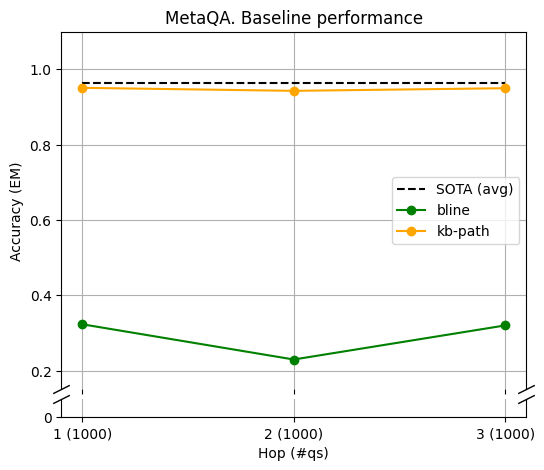

In [432]:
colors = {
    "bline": "green",
    "kb-path": "orange",
}

fig, tax, ax = get_broken_figure(0.15)

nm1_data = get_n_data(data, "kb", -1)
ndata = get_n_data(data, "kb", 0)
np1_data = get_n_data(data, "kb", 1)
datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
}
# 
plot_sota(tax)
for j,k in enumerate(datas.keys()):
    tax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{int(i)} ({data.loc[i, 'total']})" for i in data.index.values])

tax.set_title("MetaQA. Baseline performance")
plt.xlabel("Hop (#qs)")
tax.set_ylabel("Accuracy (EM)")
tax.legend()
plt.grid()
print(
    "baseline", data[["bline_p", "bline2_p"]].mean(axis=1).mean().round(3),
    "kb-path", data["kb-path_p"].mean().round(3),
)
# Display the plot
plt.show()


n-1
0.331
n
0.485
n+1
0.511


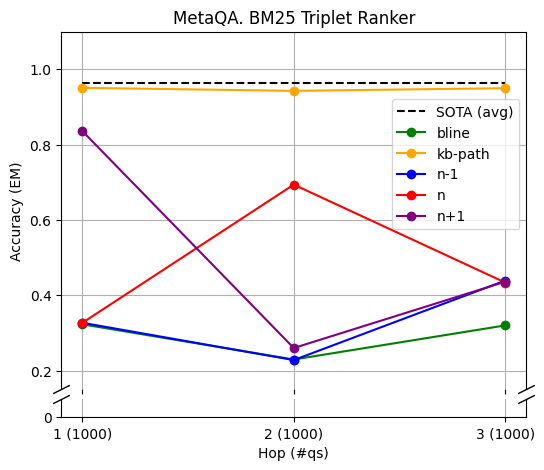

In [436]:
colors = {
    "bline": "green",
    "kb-path": "orange",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
    # "kb1_p": "blue",
    # "kb2_p": "red",
    # "kb3_p": "purple",
    # "kb4_p": "brown",
}

fix, ax, bax = get_broken_figure(0.15)

nm1_data = get_n_data(data, "kb", -1)
ndata = get_n_data(data, "kb", 0)
np1_data = get_n_data(data, "kb", 1)
datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data,
    # "kb1_p": data["kb1_p"],
    # "kb2_p": data["kb2_p"],
    # "kb3_p": data["kb3_p"],
    # "kb4_p": data["kb4_p"],
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{int(i)} ({data.loc[i, 'total']})" for i in data.index.values])


ax.set_title("MetaQA. BM25 Triplet Ranker")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend(
    loc="upper right",
    bbox_to_anchor=(1, 0.83)
)
plt.grid()
print(
    "n-1", round(sum(nm1_data) / len(nm1_data), 3),
    "n", round(sum(ndata) / len(ndata), 3),
    "n+1", round(sum(np1_data) / len(np1_data), 3),
    sep="\n"
)
# Display the plot
plt.show()


n-1
0.33
n
0.483
n+1
0.647


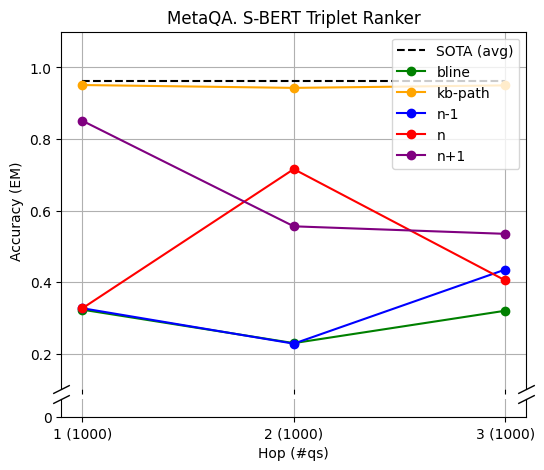

In [437]:
colors = {
    "bline": "green",
    "kb-path": "orange",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
    # "kb1_p": "blue",
    # "kb2_p": "red",
    # "kb3_p": "purple",
    # "kb4_p": "brown",
}

fig, ax, bax = get_broken_figure(bottom_lim=0.1)

nm1_data = get_n_data(data, "sbert-kb", -1)
ndata = get_n_data(data, "sbert-kb", 0)
np1_data = get_n_data(data, "sbert-kb", 1)
# 
datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data,
    # "sbert-kb1_p": data["sbert-kb1_p"],
    # "sbert-kb2_p": data["sbert-kb2_p"],
    # "sbert-kb3_p": data["sbert-kb3_p"],
    # "sbert-kb4_p": data["sbert-kb4_p"],
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{int(i)} ({data.loc[i, 'total']})" for i in data.index.values])


ax.set_title("MetaQA. S-BERT Triplet Ranker")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend()
plt.grid()
print(
    "n-1", round(sum(nm1_data) / len(nm1_data), 3),
    "n", round(sum(ndata) / len(ndata), 3),
    "n+1", round(sum(np1_data) / len(np1_data), 3),
    sep="\n"
)
# Display the plot
plt.show()


In [26]:
def get_n_data(data, set_name, delta=0):
    return [
        data.loc[hop, f"{set_name}{int(hop)+delta}_p"]
        for hop in data.index
    ]

bm25
0.485
sbert
0.483
tog-lp
0.265


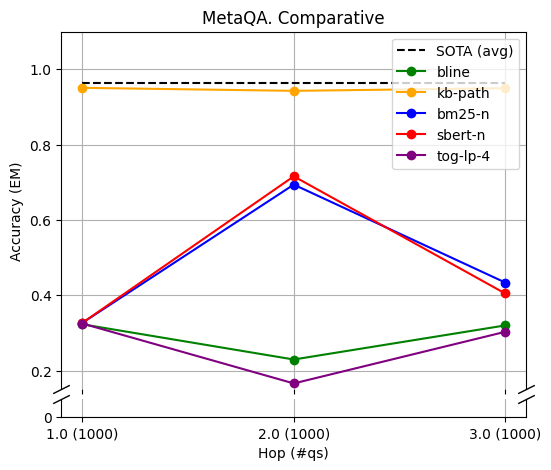

In [438]:
# "": data["tog-lp-1_p"].values
colors = {
    "bline": "green",
    "kb-path": "orange",
    "bm25-n": "blue",
    "sbert-n": "red",
    "tog-lp-4": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, ax, bax = get_broken_figure(0.15)


bm25 = get_n_data(data, "kb", 0)
sbert = get_n_data(data, "sbert-kb", 0)

datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "bm25-n": bm25,
    "sbert-n": sbert,
    "tog-lp-4": data["tog-lp-4_p"]
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])


ax.set_title("MetaQA. Comparative")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend()
plt.grid()
print(
    "bm25", round(sum(bm25) / len(bm25), 3),
    "sbert", round(sum(sbert) / len(sbert), 3),
    "tog-lp", round(sum(data["tog-lp-4_p"]) / len(data["tog-lp-4_p"]), 3),
    sep="\n"
)
# Display the plot
plt.show()
